# Anomaly Detection - Isolation Forest

Anomaly detection is the process of identifying data points that deviate significantly from the norm. These deviations are called anomalies or outliers. Isolation Forest is an effective algorithm for anomaly detection, especially in high-dimensional datasets.

How Isolation Forest Works ?

* Isolation: The algorithm "isolates" anomalies rather than profiling normal data points.
* Isolation Trees: Isolation Forest builds an ensemble of Isolation Trees (iTrees). These are binary search trees.
* Random Partitioning: In each iTree, data points are recursively partitioned by randomly selecting a feature and then randomly selecting a split value within the range of that feature.
* Path Length: The number of splits required to isolate a data point is called the "path length."
* Anomalies Have Shorter Paths: Anomalies, being different from normal data, tend to be isolated in fewer splits, resulting in shorter path lengths.

Algorithm Steps

* Build Isolation Trees: Create a forest of iTrees. Each tree is built as follows:
* Randomly select a subset of the data.

For each data point in the subset:

* Randomly select a feature.
* Randomly select a split value for that feature.
* Partition the data point to the left or right child node based on the feature value and the split value.
* Repeat until the data point is isolated or a tree height limit is reached.
* Calculate Path Lengths: For each data point, calculate its path length in each iTree.
* Compute Anomaly Score: Average the path lengths for each data point across all iTrees.
* Identify Anomalies: Data points with significantly shorter average path lengths are considered anomalies. A threshold can be used to flag data points as anomalous or normal.

Example: Detecting Fraudulent Credit Card Transactions

* Consider a dataset of credit card transactions with features like transaction amount, time of day, location, and merchant category.
* Normal Transactions: Most transactions are of small amounts, occur during typical business hours, and are from familiar locations and merchants.
* Anomalous Transactions: Fraudulent transactions might have unusually large amounts, occur at odd hours, or originate from unfamiliar locations or merchants.

Using Isolation Forest:

* The Isolation Forest algorithm builds iTrees by randomly partitioning the transaction data based on the features.
* Normal transactions, being similar to most other transactions, require more splits to isolate.
* Fraudulent transactions, being different, are isolated more quickly (shorter path lengths).
* The algorithm assigns an anomaly score to each transaction based on the average path length across all iTrees.
* Transactions with high anomaly scores (shorter average path lengths) are flagged as potentially fraudulent.

Advantages of Isolation Forest

* Effective in high-dimensional datasets.
* Computationally efficient with linear time complexity.
* Works well for global anomalies.

Limitations

* May not be as effective for local anomalies (anomalies that are only different in a small neighborhood of data points).
* Performance depends on the choice of parameters like the number of trees and the subsample size.

# 1. Import necessary dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Import the dataset and perform initial analysis

In [2]:
df = pd.read_csv('entertainment.csv')

In [3]:
df.head()

,name,books,tv_shows,video_games
0,Aaliyah,0.5,4.6,4.9
1,Abigail,0.0,4.5,4.8
2,Addison,0.5,4.5,5.0
3,Adeline,3.5,4.5,6.6
4,Alana,2.8,3.8,5.6


In [4]:
df.shape

(150, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         150 non-null    object 
 1   books        150 non-null    float64
 2   tv_shows     150 non-null    float64
 3   video_games  150 non-null    float64
dtypes: float64(3), object(1)
memory usage: 4.8+ KB


In [6]:
df.describe()

,books,tv_shows,video_games
count,150.000000,150.000000,150.000000
mean,2.993333,4.586000,5.843333
std,1.917761,0.645587,0.828066
min,0.000000,3.000000,4.300000
25%,0.800000,4.200000,5.100000
50%,3.200000,4.500000,5.800000
75%,4.500000,4.900000,6.400000
max,6.200000,6.600000,7.900000


### Univariate Analysis of Numerical variables

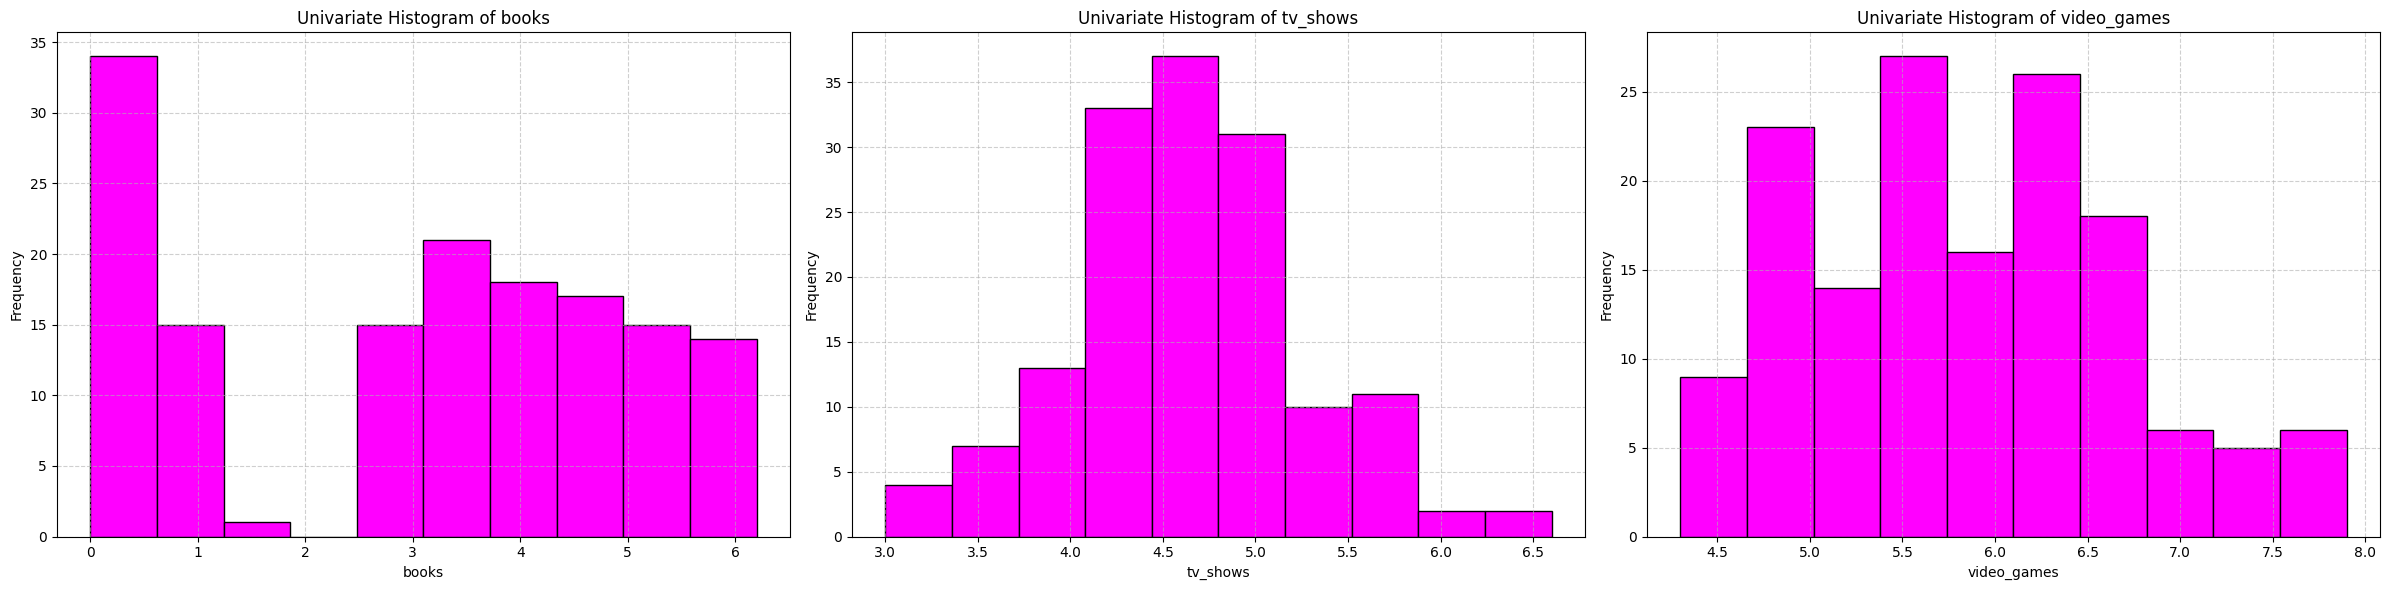

In [7]:
# List of the columns you want to create histograms for
columns_to_plot = ['books', 'tv_shows', 'video_games']

# Create a figure and a set of subplots
num_plots = len(columns_to_plot)
fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))  # Adjust figure width

# Create a histogram for each specified column in its respective subplot
for i, column in enumerate(columns_to_plot):
    ax = axes[i]  # Select the current subplot
    df[column].hist(bins=10,color = 'magenta' , edgecolor='black', ax=ax)  # Use the 'ax' argument
    ax.set_title(f'Univariate Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

### Summarizing the insights

1. Books:

* The distribution for "books" appears to be right-skewed.
* There's a high frequency of individuals with very low scores (around 0-1).
* The frequency then decreases, with smaller peaks around the 3-4 range and then again around the 5-6 range.
* This suggests that most individuals in this dataset have a low affinity for books based on this metric, with fewer individuals showing higher levels of engagement.

2. TV Shows:

* The distribution for "tv_shows" seems to be approximately normal or slightly left-skewed.
* The highest frequency of individuals falls in the range of around 4.5 to 5.0. There are noticeable frequencies around the 4.0-4.5 range as well.
* The frequencies tend to decrease as the scores move away from this central tendency towards both lower and higher values.
* This suggests a relatively consistent and moderate level of engagement with TV shows across the individuals in the dataset.

3. Video Games:

* The distribution for "video games" appears to be multimodal, with several peaks.
* There are noticeable peaks in frequency around the 4.5-5.0 range, the 5.5-6.0 range, and possibly a smaller one around the 7.0-7.5 range.
* There are also lower frequencies in the ranges between these peaks.
* This indicates that there are distinct groups of individuals with different levels of engagement with video games, rather than a single central tendency.

In summary:

* Engagement with books is generally low, with a few individuals showing higher engagement.
* Engagement with TV shows is more consistent and centered around a moderate level.
* Engagement with video games shows distinct groups with varying levels of affinity, suggesting different preferences within the dataset.

# 3. Data preparation for Anomaly Detection

*  No Missing Values : Isolation Forest works by partitioning data points based on feature values. Missing values disrupt this process, as the algorithm doesn't know where to place data points with incomplete information.
* Only Numerical Columns : Isolation Forest partitions data based on numerical feature values. It cannot directly process categorical data.
* Feature Scaling : Isolation Forest is generally not very sensitive to the scale of features. It works by isolating points through random partitioning, and the splits are not directly influenced by the magnitude of the values.

### A. Check for missing values

In [8]:
df.isnull().sum()

,0
name,0
books,0
tv_shows,0
video_games,0


No missing values

### B. Investigated the data types and dropped accordingly

In [9]:
df.dtypes

,0
name,object
books,float64
tv_shows,float64
video_games,float64


In [10]:
# keep only the numeric columns
data = df.iloc[:, 1:]
data.head()

,books,tv_shows,video_games
0,0.5,4.6,4.9
1,0.0,4.5,4.8
2,0.5,4.5,5.0
3,3.5,4.5,6.6
4,2.8,3.8,5.6


# 4. Build an Isolation forest model for Anomaly detection

The code snippet uses the scikit-learn library to train an Isolation Forest model. First, it imports the IsolationForest class. Then, it creates an instance of the model, specifying that it should identify 2% of the data as anomalies (contamination=0.02). Finally, it fits the model to your dataset (data), allowing the model to learn the underlying patterns of the normal data points.

In [11]:
# import isolation forest from sklearn
from sklearn.ensemble import IsolationForest

# fit an isolation forest model with 2% of the data set as anomalies
model = IsolationForest(contamination=0.02)
model.fit(data)

IsolationForest(contamination=0.02)

In [12]:
# view the anomaly scores

df['anomaly_scores'] = model.decision_function(data)
df.sort_values('anomaly_scores').head()

,name,books,tv_shows,video_games,anomaly_scores
110,Octavia,5.0,5.7,7.9,-0.026332
15,Avery,1.0,6.6,5.7,-0.012768
147,Zara,5.5,5.7,7.7,-0.004543
37,Elena,0.8,3.4,4.5,0.000093
29,Clementine,6.2,5.4,7.2,0.000181


In [13]:
# view the anomaly flags

df['anomaly'] = model.predict(data)
df.sort_values('anomaly_scores').head(10)

,name,books,tv_shows,video_games,anomaly_scores,anomaly
110,Octavia,5.0,5.7,7.9,-0.026332,-1
15,Avery,1.0,6.6,5.7,-0.012768,-1
147,Zara,5.5,5.7,7.7,-0.004543,-1
37,Elena,0.8,3.4,4.5,0.000093,1
29,Clementine,6.2,5.4,7.2,0.000181,1
58,Hailey,2.5,3.0,5.0,0.021340,1
19,Bianca,5.8,3.9,7.7,0.028584,1
148,Zoe,0.0,6.1,5.2,0.032181,1
42,Elizabeth,0.0,4.5,4.3,0.044760,1
129,Sofia,0.5,6.0,5.8,0.071283,1


Analysis

In the output you provided, the column anomaly contains values of either "1" or "-1". Here's how to interpret these values in the context of Isolation Forest:

* -1: Indicates that the Isolation Forest model has identified this row as an anomaly.
* 1: Indicates that the model considers this row to be a normal data point.

In [14]:
df['anomaly'].value_counts()

,count
anomaly,
1,147
-1,3


2% of 150 datapoints is 3 , that's why we have 3 outliers ( labeled as -1 )

# 5. Visualize the Anomalies

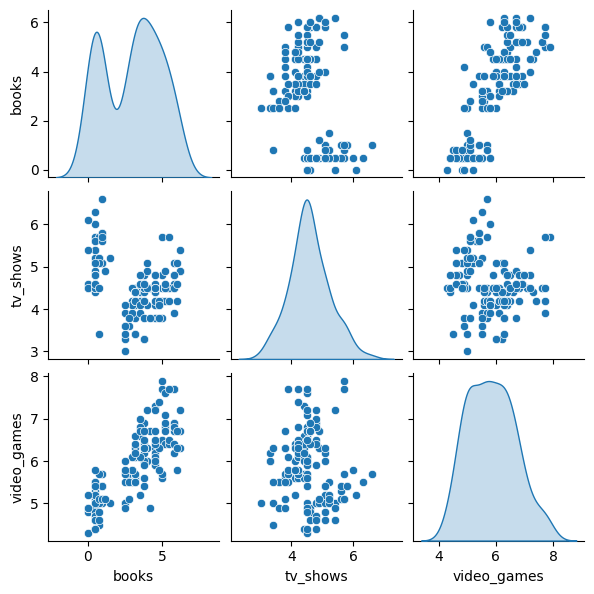

In [15]:
# view a pair plot of the original data set
import seaborn as sns

sns.pairplot(data, diag_kind='kde', height=2);

<Figure size 1500x1000 with 0 Axes>

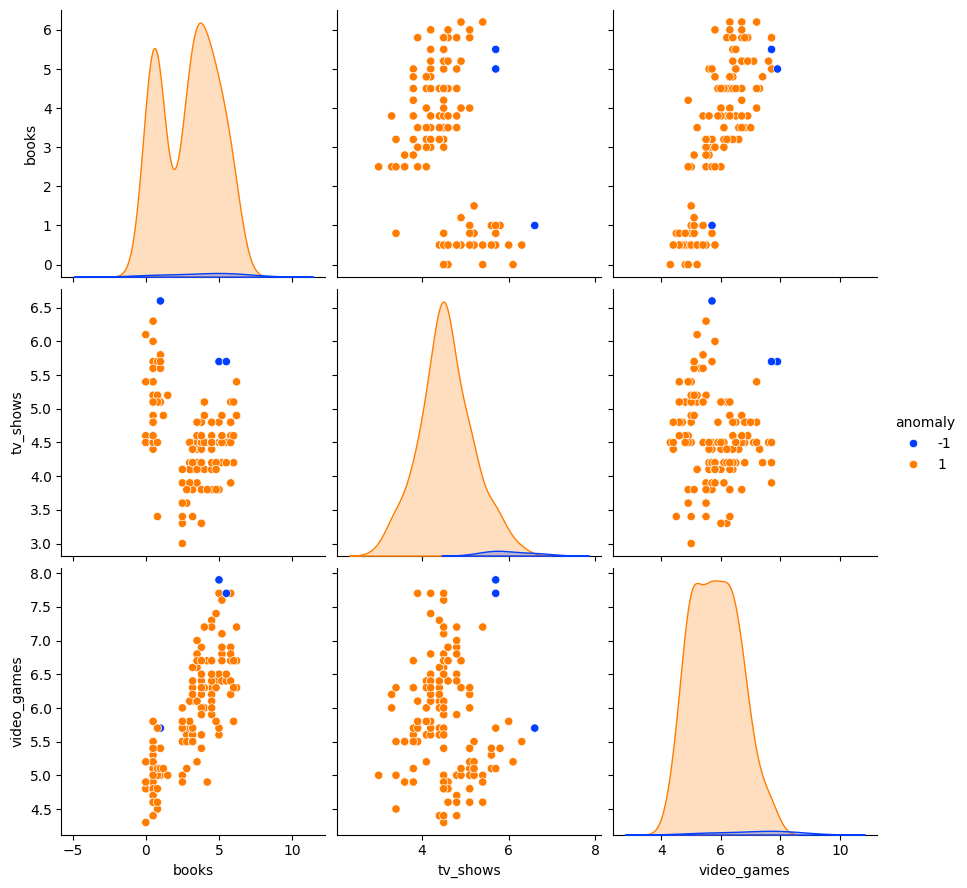

In [16]:
# overlay the isolation forest detected outliers
plt.figure(figsize=(15, 10))
sns.pairplot(df.drop(columns='anomaly_scores'), hue='anomaly', palette='bright', height=3);
plt.show();

# 6. Finetune the Isolation Forest Model with different contamination rate

In [17]:
# update the model to flag 5% of rows as anomalies

model5 = IsolationForest(contamination=0.05)
model5.fit(data)

IsolationForest(contamination=0.05)

In [18]:
# view the anomaly scores

df['anomaly_scores_5'] = model5.decision_function(data)
df.sort_values('anomaly_scores_5').head()

,name,books,tv_shows,video_games,anomaly_scores,anomaly,anomaly_scores_5
15,Avery,1.0,6.6,5.7,-0.012768,-1,-0.045083
110,Octavia,5.0,5.7,7.9,-0.026332,-1,-0.039977
37,Elena,0.8,3.4,4.5,0.000093,1,-0.039478
29,Clementine,6.2,5.4,7.2,0.000181,1,-0.031637
147,Zara,5.5,5.7,7.7,-0.004543,-1,-0.025285


In [19]:
# view the anomaly flags
df['anomaly_5'] = model5.predict(data)
df.sort_values('anomaly_5').head(10)

,name,books,tv_shows,video_games,anomaly_scores,anomaly,anomaly_scores_5,anomaly_5
15,Avery,1.0,6.6,5.7,-0.012768,-1,-0.045083,-1
19,Bianca,5.8,3.9,7.7,0.028584,1,-0.003645,-1
29,Clementine,6.2,5.4,7.2,0.000181,1,-0.031637,-1
37,Elena,0.8,3.4,4.5,0.000093,1,-0.039478,-1
42,Elizabeth,0.0,4.5,4.3,0.044760,1,-0.012199,-1
110,Octavia,5.0,5.7,7.9,-0.026332,-1,-0.039977,-1
147,Zara,5.5,5.7,7.7,-0.004543,-1,-0.025285,-1
148,Zoe,0.0,6.1,5.2,0.032181,1,-0.001462,-1
7,Amara,3.2,4.5,5.6,0.214326,1,0.175686,1
8,Amelia,0.0,4.6,4.9,0.140393,1,0.081786,1


<Figure size 1500x1000 with 0 Axes>

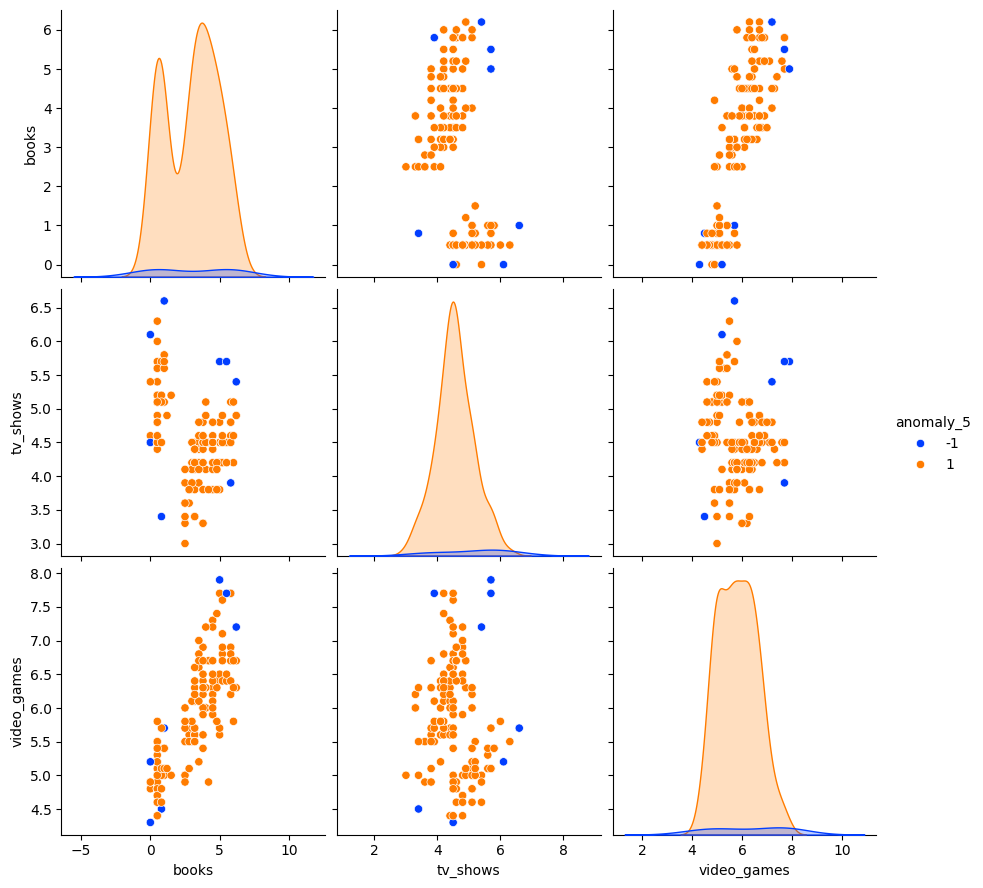

In [20]:
# overlay the isolation forest detected outliers

plt.figure(figsize=(15, 10))
sns.pairplot(df.drop(columns=['anomaly_scores', 'anomaly', 'anomaly_scores_5']), hue='anomaly_5', palette='bright', height=3);
plt.show();

# How is the Contamination Rate Chosen?

The contamination rate in Isolation Forest represents the proportion of anomalies that you expect to be present in your dataset.  It's a crucial parameter because it directly influences the algorithm's sensitivity in detecting outliers.  Here's a breakdown of how it's typically chosen:

* Knowledge of the Data: If you have prior knowledge about your data and a reasonable estimate of the percentage of outliers, you should use that as your contamination rate.  For example, in manufacturing quality control, you might know that 1% of products are typically defective.
* No Prior Knowledge: In many cases, you won't have a precise idea of the outlier percentage.  In such situations, you might:

  * Start with a default value (often 0.1 or 0.01, i.e., 10% or 1%).
  * Experiment with different contamination rates and evaluate the results.

* Evaluation Metrics: You can use metrics to help you choose the best contamination rate:

  * If you have labeled data (i.e., you know which points are truly anomalies), you can use metrics like precision, recall, F1-score, or AUC to evaluate how well the Isolation Forest performs with different contamination rates.
  * If you don't have labeled data, you can use unsupervised metrics or visual inspection to assess the quality of the outlier detection.
  * Iterative Approach: It's often a good idea to try several contamination rates (e.g., 0.01, 0.02, 0.05, 0.1) and see how the results change.  This will help you understand the sensitivity of the algorithm to this parameter.

Is it Purely a Business Decision?

While the contamination rate is heavily influenced by the characteristics of the data (which might be dictated by the business context), it's not purely a business decision. It's a combination of:

* Data Understanding: The nature of your data, its sources, and the expected proportion of outliers.
* Business Context: The implications of false positives (incorrectly labeling a normal point as an anomaly) versus false negatives (failing to detect a true anomaly).  This is where business priorities come in.
* Experimentation and Evaluation:  Trying different values and using metrics to guide the selection.

In summary, while business considerations play a significant role in determining the acceptable balance between false positives and false negatives, the choice of the contamination rate also relies on understanding the data and using appropriate evaluation techniques.